# Detecting epileptic seizures from EEG signals


## CS 109A Data Science, Harvard University


### Hannah Bend, Sathish Kumar, Yohann Smadja and Sanjay Tiwari


#### December 9, 2016


### 0. First steps
1. Download the file https://physionet.org/physiobank/database/chbmit/chb01/chb01_03.edf
2. Download the files in the repository https://github.com/stiwarih/hssyp/tree/master/project to the same folder as the notebook and unzip the csv files. To run this notebook, please run the first cells to install and load the necessary libraries.

In [2]:
# Please start by installing those two Python packages
#!pip install pyedflib
#!pip install PyWavelets

In [15]:
# And load those libraries
import pyedflib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D   
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn import linear_model
import pywt
import matplotlib.patches as patches
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier as KNN

In [3]:
# Load the edf file
f = pyedflib.EdfReader("H:\Harvard CS109a\Seizures\edf files\chb01_03.edf")
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)

# and load the data into a DataFrame
df_signals = pd.DataFrame(sigbufs)
df_signals = df_signals.transpose()
df_signals.columns = signal_labels

## 1 Introduction

### 1.1 Epilepsy and Seizures

The epilepsy is most common neurological disorder in which clusters of nerve cells (neurons), in
the brain sometimes signal abnormally and cause seizures. Currently it affects 60 million people
all over the world. Normal function of neurons is to generate electrical and chemical signals that
act on other neurons, in turn cause secondary actions leading to a desired behavior. During a
seizure, many neurons try to send signal at the same time, this abnormal surge of excessive elec-
trical activity causes involuntary movements, and may cause a loss of control, lapse of attention
or whole-body convulsion.

The introduction of new anti-epileptic drugs has made the most patient control the anti-
epileptic disorder, still one-third of people with epilepsy continue to have seizures despite treat-
ment. In addition, the nature of the disease is quite unpredictable creates signifcant anxiety to
the patients, mainly due to the fact that patients can experience loss of control and/or awareness.
Thus detection and future predictions are key to minimize or eliminate the anxiety and fears at
least in the cases where drug has no effect. A device able to detect seizures quickly could also
improve patient care.


### 1.2 A classification problem

Seizure detection is usually done using scalp electroencephalogram (EEG), a non-invasive, multi-
channel recording of the brain's electrical activity. Classification between a normal activity and
a seizure is usually done in two steps: noise filtering and classifcation. We propose here two
approaches to noise filtering. We will use two transforms, Fourier and Discrete wavelets, to filter
the data but also extract the useful information and structure behind the signals. We will test
classical models of classification and Python's sklearn libraries to run them.


### 1.3 Data

A study was conducted at the Children's Hospital Boston where EEG was recorded on pediatric
subjects with intractable (i.e. epileptic) seizures. There were 22 subjects in the study: 5 male, ages
3-22, and 17 females, ages 1.5-19; subject 21 was evaluated a second time 1.5 years later, thus re-
sulting in 23 cases. Each case contains between 9 and 42 continuous .edf fles from a single subject,
typically consisting of one hour each. Prior to measuring, subjects were taken of of any anti-
seizure medication. The files can be found at https://physionet.org/physiobank/database/chbmit/


### 1.4 EEG Samples

Most of the EEG files have 23 recordings from electrodes placed around the head of the patient.
Figures 1 presents two EEG recordings of 40 seconds each. The first one was recorded at 1:43pm,
while the patient was awake, and so should represent normal activity of the brain. The second
one was recorded 50 minutes later. Within this 40 seconds, the patient experiences one epileptic
seizure. As the size of the EEG makes it diffcult to assess how much bigger the amplitudes are
when the patient is experiencing a seizure, Figure 2 zooms in on one channel for the non-seizure
and seizure activity. Here we begin to see a marked difference between the two.

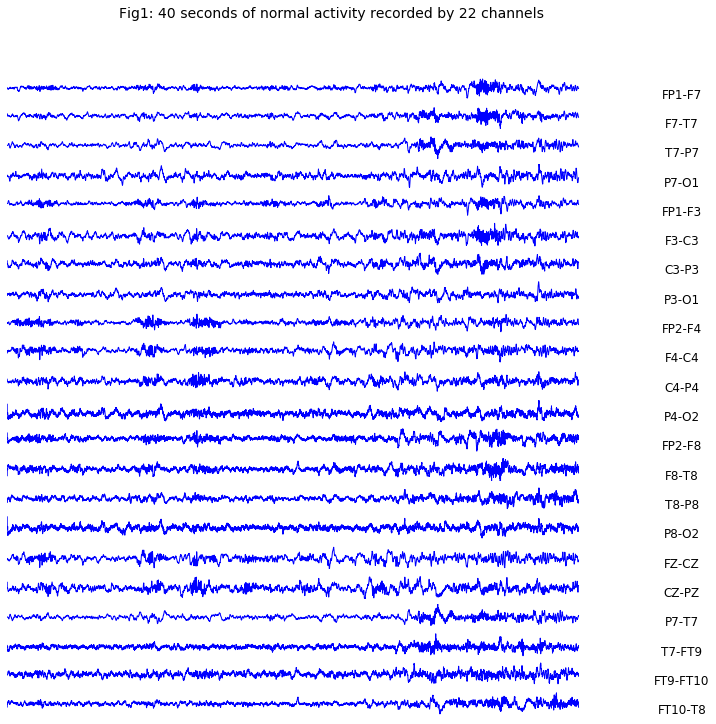

In [5]:
ax = ['ax'+str(i) for i in range(23)]
C = df_signals.columns
plt.figure(figsize=(12,12))
plt.suptitle("Fig1: 40 seconds of normal activity recorded by 22 channels", fontsize= 14)
for i in range(22): 
    ax[i] = plt.subplot(23,1,i+1)
    ax[i].plot(df_signals[C[i]].iloc[0:10240],"blue")
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off' ,length=0) 
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["left"].set_visible(False)
    ax[i].set_ylabel(C[i], fontsize=12, rotation=0)
    ax[i].yaxis.set_label_position("right")

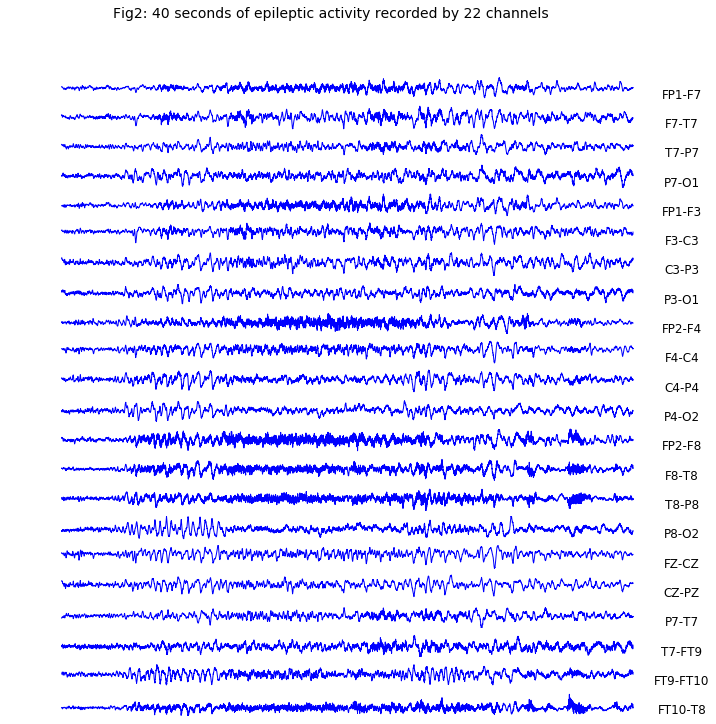

In [6]:
ax = ['ax'+str(i) for i in range(23)]
C = df_signals.columns

plt.figure(figsize=(12,12))
plt.suptitle("Fig2: 40 seconds of epileptic activity recorded by 22 channels", fontsize= 14)
for i in range(22): 
    ax[i] = plt.subplot(23,1,i+1)
    ax[i].plot(df_signals[C[i]].iloc[766976:(777216)],"blue")
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off' ,length=0) 
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["left"].set_visible(False)
    ax[i].set_ylabel(C[i], fontsize=12, rotation=0)
    ax[i].yaxis.set_label_position("right")

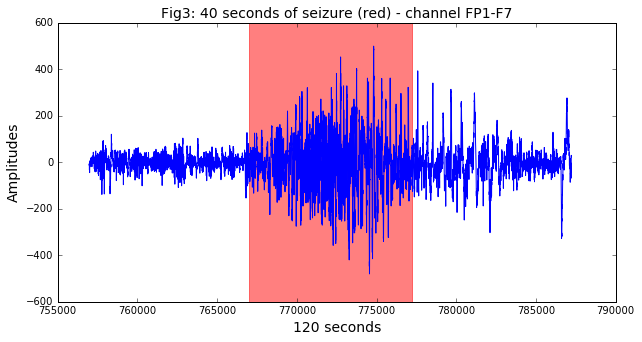

In [7]:
plt.figure(figsize=(10,5))
plt.plot(df_signals['FP1-F7'].iloc[756976:787216])
plt.axvspan(766976, 777216, alpha=0.5, color='red')
plt.title("Fig3: 40 seconds of seizure (red) - channel FP1-F7", fontsize =14)
plt.xlabel("120 seconds", fontsize =14)
plt.ylabel("Amplitudes", fontsize =14)
plt.ylim((-600,600))
plt.show()

### 1.5. Data cleaning

We have noticed that the channel T8-P8 appears twice in the EEG files. The name and the time
series are identical. We also notice that the channel T7-P7 and P7-T7 (logically) present the same
information. The dataset was used for the phD thesis of Ali Shoeb who makes no mention of cleaning the data but does lter the signals before doing any feature engineering.


## 2. Feature Engineering

Higher EEG amplitudes is not the only factor to detect a seizure. The brain's activity is often
composed of multiple frequency components. We will study the presence or absence of some
components to classify what is a seizure and what is not. We used two techniques to extract the
components from the original time series: The Fourier transform and Discrete Wavelet transform.

### 2.1. Fourier Transform

The Fourier decomposes the EEG time series into a voltage by frequency spectral graph com-
monly called the "power spectrum", with power being the square of the EEG magnitude, and
magnitude being the integral average of the amplitude of the EEG signal, measured from (+)peak
to (-)peak), across the time sampled, or epoch. This transform helps us visualize the structure
behind the signal.

EEG signals can quickly vary over time even during a seizure. They are non-stationary signals
hence we will compute power spectrum densities on short intervals. We used two-second epochs
like Shoeb and Guttag suggested in their article.

Figure 4 below presents the power spectrum of 20 two-second epochs recorded by the FP1-
F7 channel. The three on the right are from normal activity and the three on the right are
from the same seizure. We focus on the [0:25Hz] interval where most of the epileptic activity is.
Comparing normal to mid-seizure, it is clear that the power spectrum peaks differ both in count
and width, indicating that the magnitude of a wave for a given frequency differs between normal
activity and seizures.

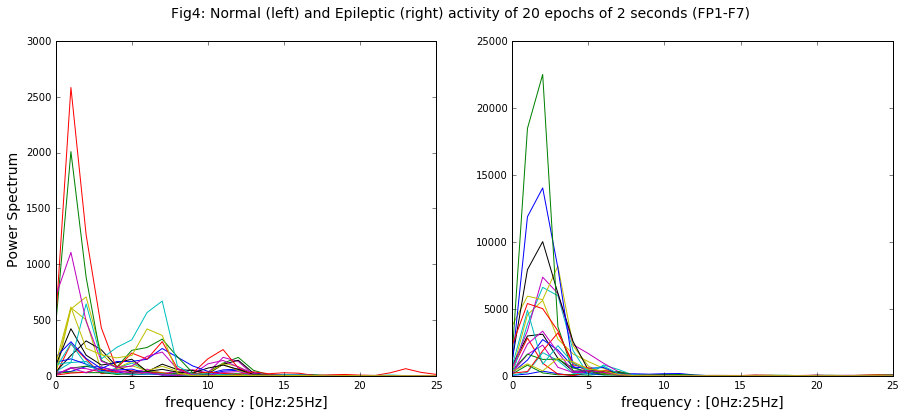

In [10]:
df_signals.columns.values[22] = 'FP2-F8'
plt.figure(figsize=(15,6))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
for i in range(20):
    power1, freqs1 = matplotlib.mlab.psd(df_signals[df_signals.columns[0]].iloc[(512*i):(512*(i+1))], NFFT=256, Fs=256)
    power2, freqs2 = matplotlib.mlab.psd(df_signals[df_signals.columns[0]].iloc[(766976+512*i):(766976+512*(i+1))], NFFT=256, Fs=256)
    ax1.plot(freqs1, power1)
    ax2.plot(freqs2, power2)
ax1.set_xlim((0, 25))    
ax2.set_xlim((0, 25))
ax1.set_xlabel('frequency : [0Hz:25Hz]', fontsize=14)   
ax2.set_xlabel('frequency : [0Hz:25Hz]', fontsize=14)
ax1.set_ylabel('Power Spectrum', fontsize=14)
plt.suptitle("Fig4: Normal (left) and Epileptic (right) activity of 20 epochs of 2 seconds (FP1-F7)", fontsize=14)
plt.show()

The next figure shows the power spectrum of the 22 EEG channels for 2 seconds of normal
and epileptic activity. It is important to include the recordings of all channels as they represent
different area of the brain. They each provide some unique information that will help our classifier.

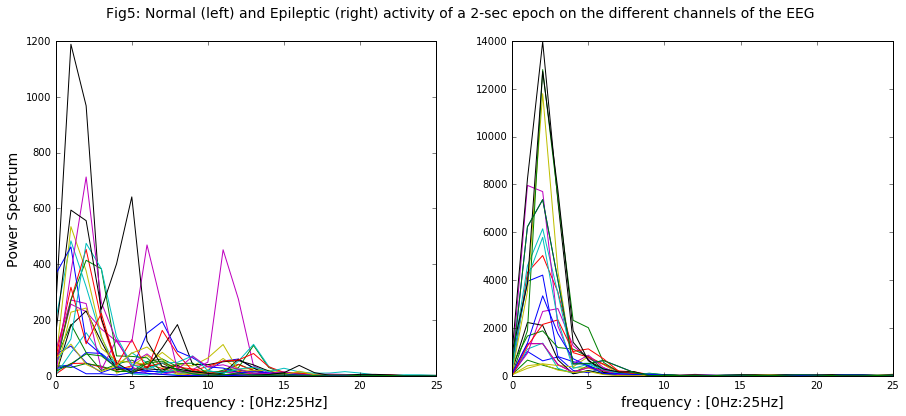

In [11]:
df_signals.columns.values[22] = 'T8-P8(2)'
plt.figure(figsize=(15,6))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
for i in range(len(df_signals.columns)):
    power1, freqs1 = matplotlib.mlab.psd(df_signals[df_signals.columns[i]].iloc[(512*i):(512*(i+1))], NFFT=256, Fs=256)
    power2, freqs2 = matplotlib.mlab.psd(df_signals[df_signals.columns[i]].iloc[768976:(768976+512)], NFFT=256, Fs=256)
    ax1.plot(freqs1, power1)
    ax2.plot(freqs2, power2)
ax1.set_xlim((0, 25))    
ax2.set_xlim((0, 25))
ax1.set_xlabel('frequency : [0Hz:25Hz]', fontsize=14)   
ax2.set_xlabel('frequency : [0Hz:25Hz]', fontsize=14)
ax1.set_ylabel('Power Spectrum', fontsize=14)
plt.suptitle("Fig5: Normal (left) and Epileptic (right) activity of a 2-sec epoch on the different channels of the EEG", fontsize=14)
plt.show()

### 2.2. Brainwaves

Neural oscillations can be observed at all time even when a patient is resting or sleeping. A great
analogy is to think of those oscillations as musical notes. Waves with low frequency are like a
4deeply penetrating drum beat while brainwaves with high frequency are like a high pitched flute.
We can see the EEG signals as the partition of a symphony.

• Delta waves (.5 to 3 Hz): Delta brainwaves have the lowest frequency. They are usually
generated in deep meditation or dreamless sleep.

• Theta waves (3 to 8 HZ): Theta brainwaves occur most often in sleep and states of reduced
consciousness. Theta waves dominate when our body falls asleep. We will see later that
those waves are the most important ones during epileptic events.

• Alpha waves (8 to 12 Hz): Alpha brainwaves are dominant when we are quietly thinking
and resting.

• Beta waves (12 to 38 Hz): Beta brainwaves dominate our normal waking state of consciousness
when attention is directed towards cognitive tasks and the outside world.

Most of the epileptic activity is concentrated in those waves. After computing the power spectrum
for each channel on 2-second epochs, we average the powers for each of the 4 brain waves.
We now have 88 time series representing the brain activity of our patient. Figure 6 below shows
2D scatter plots of alpha and delta waves for the FP1-T7 channel. We notice that the classification
might be easier during the night than during the day. The three scatter plots below show the average
powers of delta and alpha waves during seizure episodes and during normal activity during
the night or the day. The last two show the channels carry different information. 

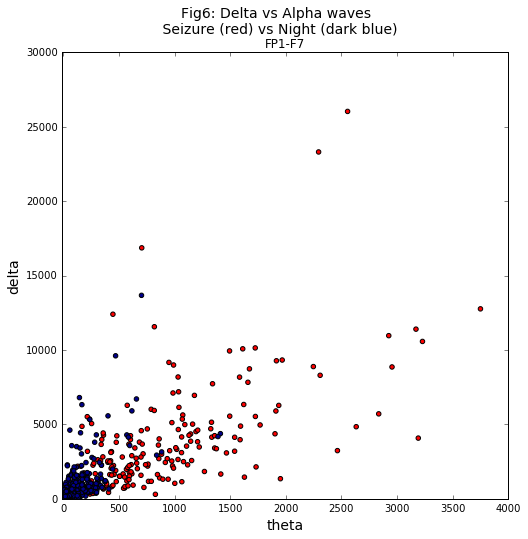

In [28]:
df_power_spectrum = pd.read_csv("H:\Harvard CS109a\Seizures\power spectrum\power_spectrum.csv")

colors = {'before':'darkblue','after':'darkblue','night':'darkblue', 'seizure':'red'}

fig = plt.figure(figsize=(8,8))
plt.suptitle("Fig6: Delta vs Alpha waves \n Seizure (red) vs Night (dark blue)",fontsize=14)
ax = fig.add_subplot(111)
ax.scatter(df_power_spectrum[df_power_spectrum["type"]!='day'][str(df_signals.columns[0])+" theta"], df_power_spectrum[df_power_spectrum["type"]!='day'][str(df_signals.columns[0])+" delta"], c = df_power_spectrum[df_power_spectrum["type"]!='day']["type"].apply(lambda x: colors[x]))
ax.set_title(df_signals.columns[0])
ax.set_ylabel("delta", fontsize=14)
ax.set_xlabel("theta", fontsize=14)
ax.set_xlim((-10,4000))
ax.set_ylim((-10,30000))
plt.show()

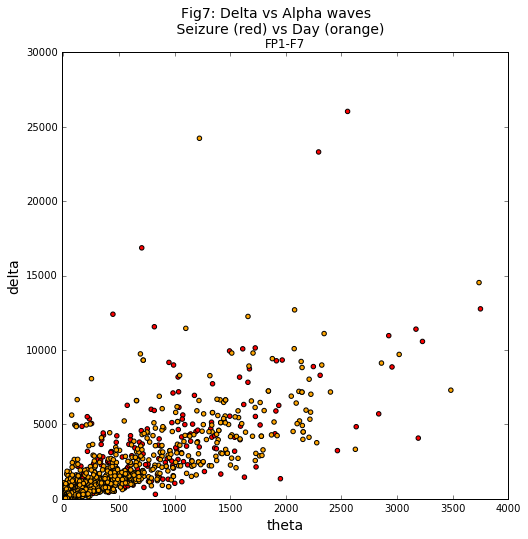

In [33]:
colors = {'day':'orange','seizure':'red'}

df_p = df_power_spectrum[(df_power_spectrum["type"]=='day')|(df_power_spectrum["type"]=='seizure')]

fig = plt.figure(figsize=(8,8))
plt.suptitle("Fig7: Delta vs Alpha waves \n Seizure (red) vs Day (orange)",fontsize=14)
ax = fig.add_subplot(111)
ax.scatter(df_p[str(df_signals.columns[0])+" theta"], df_p[str(df_signals.columns[0])+" delta"], c = df_p["type"].apply(lambda x: colors[x]))
ax.set_title(df_signals.columns[0])
ax.set_ylabel("delta", fontsize=14)
ax.set_xlabel("theta", fontsize=14)
ax.set_xlim((-10,4000))
ax.set_ylim((-10,30000))
plt.show()

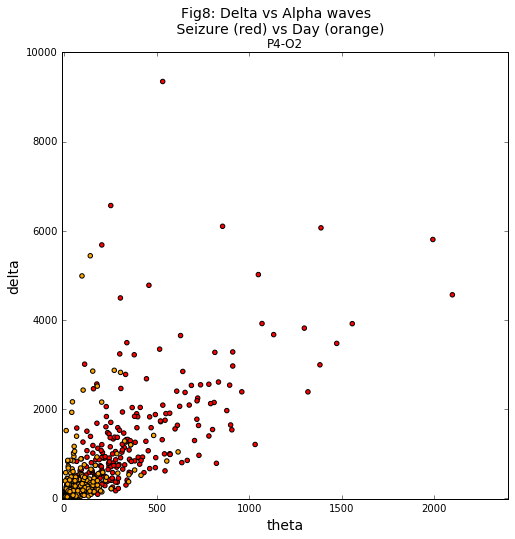

In [35]:
colors = {'day':'orange','seizure':'red'}

df_p = df_power_spectrum[(df_power_spectrum["type"]=='day')|(df_power_spectrum["type"]=='seizure')]

fig = plt.figure(figsize=(8,8))
plt.suptitle("Fig8: Delta vs Alpha waves \n Seizure (red) vs Day (orange)",fontsize=14)
ax = fig.add_subplot(111)
ax.scatter(df_p[str(df_signals.columns[11])+" theta"], df_p[str(df_signals.columns[11])+" delta"], c = df_p["type"].apply(lambda x: colors[x]))
ax.set_title(df_signals.columns[11])
ax.set_ylabel("delta", fontsize=14)
ax.set_xlabel("theta", fontsize=14)
ax.set_xlim((-10,2400))
ax.set_ylim((-10,10000))
plt.show()

### 2.3. Discrete Wavelet Transform

The wavelet transform is similar to the Fourier transform with a completely different merit function.
A key advantage it has over Fourier transforms is temporal resolution: it captures both
frequency and location information (location in time). The discrete wavelet transform (DWT) is
an implementation of the wavelet transform using a discrete set of the wavelet scales and translations
obeying some defined rules.

The DWT of a signal(x) is calculated by passing it through a series of filters. First the samples
are passed through a low pass filter with impulse response(g) and simultaneously the signal
5is also decomposed using a high-pass filter(h). As an output, we get the detail and approximation
coefficients.

<img src="WaveletsDWT.png">

Half the frequencies of the signal are removed in every level of filter bank and hence half the
samples can be discarded. The decomposition is repeated to further increase the frequency resolution.
To illustrate the above, data from EEG files for channel FP1-F17 were passed through 3
levels of filter bank. The below picture shows the mother wavelet(EEG data) and the decomposed
wavelets which has been shrunk 3 times because of the DWT process.

<img src="DWT3FilterBanks.png">

Duration of the mother wavelet is one hour. For every second 28 frequencies were recorded in
the EEG. This mother wavelet was passed through 3 filter banks to decompose the wavelet by 23
times. This has significantly reduced the size of the wavelet without loosing information. Also,
we have still captured the frequency as well as location(in time) information. We will also analyze
the predictions obtained by passing the wavelet through different levels of filter banks.

We can transform EEG data to multiple wavelet forms e.g: Haar wavelets, Daubechies wavelets
etc. For our analysis, we will use Daubechies wavelets because of its high orthogonal property
which is important for detecting abrupt change in frequencies i.e. seizures. To do a comparison,
we will use Haar wavelet as well to see how the results differ. For our analysis, we will only use
partial EEG data which includes normal and seizure activity and split the corresponding wavelet
to 2 second intervals and each of these splits will become an observation. The coefficients obtained
after the wavelet transform will be used as predictors. The same procedure will be done for all
channels of the EEG.

<img src="db2_haar_wavelets.png">

As it is seen above, the shape of the ”Daubechies” wavelet matches the shape of the EEG
data. We expect to get better accuracy with daubechies wavelet.

## 3. A First (Logistic) Model

Using the average powers of brainwaves as predictors, we randomly split our model into a training
and a testing set. We used the training set to run a cross validation and find the optimal
regularization parameter. A balanced class weights logistic regression led to an accuracy of 97.9%
and 90.7% on class 0 (normal activity) and class 1 (seizure) respectively. Our classifier has a high
percentage of false positive. We missed almost 10% of epileptic states but the percentage of false
negative is low even during the day.


In [55]:
# We split the dataset for cross valivation

predictors = df_power_spectrum.columns[:-13]
X_training, X_testing, y_training, y_testing = train_test_split(df_power_spectrum[predictors], df_power_spectrum['label'], test_size=0.2, random_state=22)

print "Proportion of seizure activity in training:", round(np.sum(y_training)/(len(y_training)+0.0),3)

Proportion of seizure activity in training: 0.074


In [40]:
# Logistic Regression Cross Validation

C_param = [0.1, 0.3, 0.6, 0.8, 1, 2, 5, 10, 25, 50, 75, 100]
results_logit = pd.DataFrame(index = C_param, columns=range(50))

for k in range(25):
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_training, y_training, test_size=0.2, random_state=k)
    for j in range(len(C_param)):
        logit = linear_model.LogisticRegression(C = C_param[j], class_weight="balanced")
        logit.fit(XX_train, yy_train) 
        predictions = logit.predict(XX_test)
        results_logit[k].iloc[j] = np.sum(predictions == yy_test)

results_logit.mean(1)  

0.1      468.56
0.3      469.44
0.6      467.52
0.8      468.64
1.0      469.04
2.0      469.16
5.0      468.08
10.0     468.52
25.0     468.00
50.0     469.48
75.0     467.48
100.0    468.92
dtype: float64

In [56]:
# Results of the first model

logit = linear_model.LogisticRegression(C = 2, class_weight="balanced")
logit.fit(X_training, y_training) 
predictions = logit.predict(X_testing)

t = df_power_spectrum["type"][y_testing.index]      
a1 = np.sum((predictions==1)&(y_testing==1))
a2 = np.sum((predictions==1)&(y_testing==0))
a3 = np.sum((predictions==0)&(y_testing==1))
a4 = np.sum((predictions==0)&(y_testing==0))
d2 = np.sum((predictions==1)&(y_testing==0)&(t=="day"))
d4 = np.sum((predictions==0)&(y_testing==0)&(t=="day"))
n2 = np.sum((predictions==1)&(y_testing==0)&((t=="night")|(t=="before")|(t=="after")))
n4 = np.sum((predictions==0)&(y_testing==0)&((t=="night")|(t=="before")|(t=="after")))
         
df_pred = pd.DataFrame(columns=["Seizure","Normal - Night", "Normal - Day"], index=["Predicted Seizure","Predicted Normal"])
df_pred["Seizure"].iloc[0] = round(a1/(a1+a3+0.0),3)
df_pred["Seizure"].iloc[1] = round(a3/(a1+a3+0.0),3)
df_pred["Normal - Night"].iloc[0] = round(n2/(a2+a4+0.0) ,3)   
df_pred["Normal - Night"].iloc[1] = round(n4/(a2+a4+0.0) ,3)   
df_pred["Normal - Day"].iloc[0] = round(d2/(a2+a4+0.0) ,3)   
df_pred["Normal - Day"].iloc[1] = round(d4/(a2+a4+0.0) ,3)    
df_pred

,Seizure,Normal - Night,Normal - Day
Predicted Seizure,0.85,0.04,0.026
Predicted Normal,0.15,0.35,0.583


We can use the computed probability of class 1, of being in a state of epilepsy, to visualize
how well we are doing during the night and the day. We see a few false positives while the patient is asleep and several instances where the classifier estimates that the seizure is over while it is not. It is important to minimize the number of false negatives, predicting a non-seizure while the patient is experiencing a seizure. Seizures can be
dangerous for our patient and a quick detection can be critical.


In [57]:
# We run the logistic model on the whole dataset

logit = linear_model.LogisticRegression(C = 1, class_weight="balanced")
logit.fit(df_power_spectrum[predictors], df_power_spectrum['label']) 
df_power_spectrum["predict_proba"]=pd.DataFrame(logit.predict_proba(df_power_spectrum[predictors]))[1]

before  = df_power_spectrum[(df_power_spectrum["file"]==21)&(df_power_spectrum["type"]=='before')][["FP1-F7 delta","FP1-F7 theta","FP1-F7 alpha","FP1-F7 beta","predict_proba",'type']]
seizure  = df_power_spectrum[(df_power_spectrum["file"]==21)&(df_power_spectrum["type"]=='seizure')][["FP1-F7 delta","FP1-F7 theta","FP1-F7 alpha","FP1-F7 beta","predict_proba",'type']] 
after = df_power_spectrum[(df_power_spectrum["file"]==21)&(df_power_spectrum["type"]=='after')][["FP1-F7 delta","FP1-F7 theta","FP1-F7 alpha","FP1-F7 beta","predict_proba",'type']]
concat = pd.concat([before, seizure, after],ignore_index=True)

day = df_power_spectrum[(df_power_spectrum["file"]==25)&(df_power_spectrum["type"]=='day')][["FP1-F7 delta","FP1-F7 theta","FP1-F7 alpha","FP1-F7 beta","predict_proba",'type']]

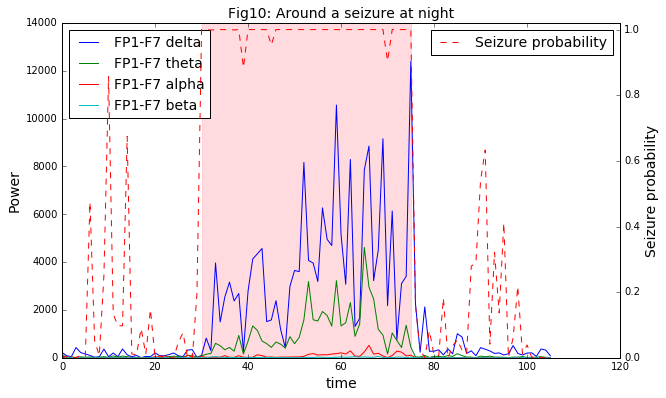

In [86]:
fig, ax1 = plt.subplots(figsize=(10,6))
for i in range(4):
    ax1.plot(concat[concat.columns[i]])
ax1.set_xlabel('time',fontsize=14)
ax1.axvspan(30, 75, alpha=0.5, color='lightpink')
ax1.set_ylabel("Power",fontsize=14)
plt.legend(loc=2,fontsize=14)
ax2 = ax1.twinx()
ax2.plot(concat[concat.columns[4]], "red", linestyle="--", label="Seizure probability")
plt.legend(loc=1,fontsize=14)
ax2.set_ylabel("Seizure probability",fontsize=14)
ax2.set_ylim((0,1.02))
plt.title("Fig10: Around a seizure at night",fontsize=14)
plt.show()

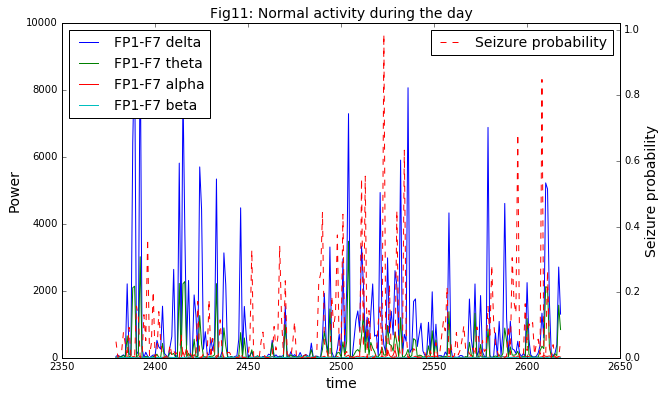

In [85]:
fig, ax1 = plt.subplots(figsize=(10,6))
for i in range(4):
    ax1.plot(day[day.columns[i]])
ax1.set_xlabel('time',fontsize=14)
ax1.set_ylabel("Power",fontsize=14)
plt.legend(loc=2,fontsize=14)
ax2 = ax1.twinx()
ax2.plot(day[day.columns[4]], "red", linestyle="--", label="Seizure probability")
plt.legend(loc=1,fontsize=14)
ax2.set_ylabel("Seizure probability",fontsize=14)
ax2.set_ylim((0,1.02))
plt.title("Fig11: Normal activity during the day",fontsize=14)
plt.show()

## 4. Feature Importance

We added to our list of predictors a dummy variable equal to 1 if the recording was during the
day, when the patient was supposedly awake, between 8am and 11pm. We also added interactions
between the powers of the most important channels. We added a total of 10 new predictors
including the dummy variable ”Day”.

We used the feature importance output from Sklearn’s random forest function to understand
what are the main predictors. Unfortunately the dummy variable is the least important feature
of the 98 predictors. On the other hand, all the interaction terms are in the top 22 features. We
could add more of them as the seem to add value to our classifier but with already 98 predictors
we if we wanted to add all of them we would have $C_2^{88} = 3828$ new features. We use a data set of
3,040 observations hence we had to select only a subset of interaction terms. Our intuition was
to focus on areas of the brain that help discriminate between seizures and normal activity.


In [76]:
# We run a cross validation for a Random Forest

predictors = df_power_spectrum.columns[:-13]
X_training, X_testing, y_training, y_testing = train_test_split(df_power_spectrum[predictors], df_power_spectrum['label'], test_size=0.2, random_state=22)

MD = [2,5,7,10,15,20,25]
results_rf = pd.DataFrame(index = MD, columns=range(20))

for k in range(20):
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_training, y_training, test_size=0.2, random_state=k)
    for j in range(len(MD)):
        rf = RandomForest(n_estimators=200, max_depth=MD[j], class_weight="balanced")
        rf.fit(XX_train, yy_train) 
        predictions = rf.predict(XX_test)
        results_rf[k].iloc[j] = np.sum(predictions == yy_test)

results_rf.mean(1) 

2     475.35
5     482.80
7     482.80
10    482.75
15    482.50
20    482.45
25    482.45
dtype: float64

In [80]:
# We run the Random Forest on the testing set

rf = RandomForest(n_estimators=300, max_depth=2, class_weight="balanced")
rf.fit(X_testing, y_testing)
predictions = rf.predict(X_testing)
        
a1 = np.sum((predictions==1)&(y_testing==1))
a2 = np.sum((predictions==1)&(y_testing==0))
a3 = np.sum((predictions==0)&(y_testing==1))
a4 = np.sum((predictions==0)&(y_testing==0))
          
df_pred = pd.DataFrame(columns=["Seizure", "Normal"], index=["Predicted Seizure","Predicted Normal"])
df_pred["Seizure"].iloc[0] = round(a1/(a1+a3+0.0),3)
df_pred["Seizure"].iloc[1] = round(a3/(a1+a3+0.0),3)
df_pred["Normal"].iloc[0] = round(a2/(a2+a4+0.0) ,3)   
df_pred["Normal"].iloc[1] = round(a4/(a2+a4+0.0) ,3)    
df_pred

,Seizure,Normal
Predicted Seizure,0.975,0.023
Predicted Normal,0.025,0.977


In [81]:
# We look at feature importance 

rf.fit(df_power_spectrum[predictors], df_power_spectrum['label'])

waves=[]
for i in range(len(predictors)):
    waves.append(predictors[i][-5:].strip())

channels=[]
for i in range(len(predictors)):
    channels.append(predictors[i][:-5].strip())
    
df_feat_imp = pd.DataFrame(rf.feature_importances_, index = predictors, columns=["importance"])
df_feat_imp["waves"] = waves
df_feat_imp["channels"] = channels
df_feat_imp = df_feat_imp.sort("importance",ascending=True)

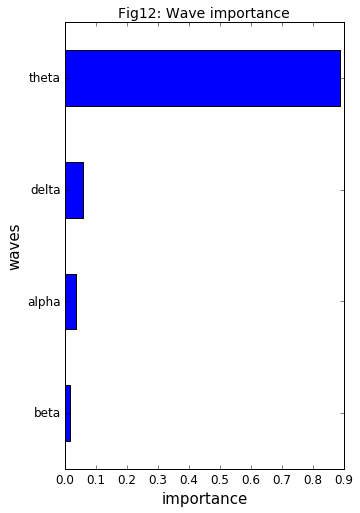

In [88]:
waves_importance = pd.pivot_table(df_feat_imp, values='importance',index = "waves", aggfunc=np.sum)
plt.figure(figsize=(5,8))
waves_importance.order(ascending=True)[-4:].plot.barh(fontsize=12)
plt.ylabel("waves",fontsize=15)
plt.xlabel("importance",fontsize=15)
plt.title("Fig12: Wave importance",fontsize=14)
plt.show()

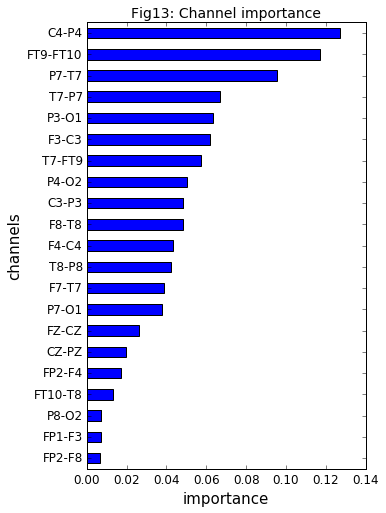

In [89]:
channels_importance = pd.pivot_table(df_feat_imp, values='importance',index = "channels", aggfunc=np.sum)
#channels_importance.order(ascending=True)
plt.figure(figsize=(5,8))
channels_importance.order(ascending=True).plot.barh(fontsize=12)
channels_importance = channels_importance.order(ascending=True)
channels_importance[1:].plot.barh()
plt.ylabel("channels",fontsize=15)
plt.xlabel("importance",fontsize=15)
plt.title("Fig13: Channel importance",fontsize=14)
plt.show()

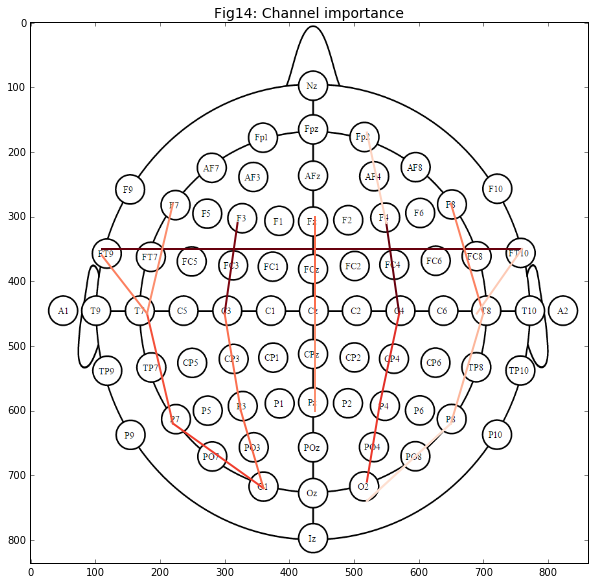

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
reds = plt.get_cmap('Reds')

image_name = "eeg_electrodes2.png"
im = plt.imread(image_name)

line = [[(110,350), (760,350)],[(550,310), (570,450)],[(320,310), (300,450)],[(570,450), (540,590)], [(540,590), (520,710)],[(220,620), (360,720)],[(220,620), (180,450)],[(325,600), (360,720)],[(440,300), (440,450)],[(300,450), (325,600)],[(180,450), (110,360)],[(650,280), (700,450)],[(220,280), (180,450)],[(440,450), (440,600)],[(700,450), (650,620)],[(760,350), (690,450)],[(520,170), (550,310)],[(650,620), (520,740)]]

for i in range(19):
    (line_xs, line_ys) = zip(*line[i-1])
    ax.add_line(Line2D(line_xs, line_ys, linewidth=2, color=reds(channels_importance[-i]/0.1)))

plt.title("Fig14: Channel importance",fontsize=14)
implot = plt.imshow(im)

## 5. Classifiers

### 5.1. Power Spectrum approach

With the number of predictors we are working with, it is impossible to visualize the relationship
between the predictors and the outcomes. Thus, we approached model selection by running cross
validations of several models on training data and compared their overall accuracy, accuracy on
class 0 (normal) and on class 1 (seizure).

We ran weighted logistic regressions, Linear and Quadratic Discriminant Analysis classifiers,
Random Forests and Gradient Boosting algorithms. We used sklearn’s functions to run those
models. The logistic regressions have balanced weighted classes and we tested different values
of the regularization parameter C. We did not run any cross validation for Linear Discriminant
Analysis and took the default parameters. We tested different values of the regularization parameter
for Quadratic Discriminant Analysis. We fixed the number of trees to 300 for Random
Forest, the classes were also balanced and we tried different depths. Finally, we set the number
of depth to 2, the learning rate to 0.01, changed the random state at every split and tried several number of trees for Gradient Boosting.

We first randomly split our dataset in a training and a testing set with proportions of 80%/20%.
We used the training set to run cross validations by splitting the training set 10 times into
80%/20% sub-training/testing sets. Below are the average accuracy on class 0, class 1 and overall
accuracy over the 10 testing sets. The results are in the tables below.

We mentioned earlier that we wanted to select a model that had the best accuracy on class
1 to be able to detect seizures as soon as possible. If models had similar performance then looking
at the overall accuracy is the next logic thing to do. Random Forest performed better than
Quadratic Discriminant Analysis and Logistic regressions that also have impressive results.

On the testing set, the Random Forest has an accuracy of 96.4% on class 0 and 95.7% on class 1.

In [91]:
# We run cross validation on QDA, GBC, Logistic regression and Random Forest

predictors = df_power_spectrum.columns[:-4]
X_training, X_testing, y_training, y_testing = train_test_split(df_power_spectrum[predictors], df_power_spectrum['label'], test_size=0.2, random_state=10)
 
MD = [2, 5, 7, 10, 15, 20, 25]
C_param = [0.1, 0.3, 0.6, 0.8, 1, 2, 5, 10, 25, 50]
QDA_param = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
GBC_param = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900]

results_lda_0 = pd.DataFrame(index = [0], columns=range(10))
results_lda_1 = pd.DataFrame(index = [0], columns=range(10))
results_lda_oa = pd.DataFrame(index = [0], columns=range(10))
results_lda = pd.DataFrame(index = [0], columns=["class 0","class 1","overall"])
results_qda_0 = pd.DataFrame(index = QDA_param, columns=range(10))
results_qda_1 = pd.DataFrame(index = QDA_param, columns=range(10))
results_qda_oa = pd.DataFrame(index = QDA_param, columns=range(10))
results_qda = pd.DataFrame(index = QDA_param, columns=["class 0","class 1","overall"])
results_rf_0 = pd.DataFrame(index = MD, columns=range(10))
results_rf_1 = pd.DataFrame(index = MD, columns=range(10))
results_rf_oa = pd.DataFrame(index = MD, columns=range(10))
results_rf = pd.DataFrame(index = MD, columns=["class 0","class 1","overall"])
results_logit_0 = pd.DataFrame(index = C_param, columns=range(10))
results_logit_1 = pd.DataFrame(index = C_param, columns=range(10))
results_logit_oa = pd.DataFrame(index = C_param, columns=range(10))
results_logit = pd.DataFrame(index = C_param, columns=["class 0","class 1","overall"])
results_gbc_0 = pd.DataFrame(index = GBC_param, columns=range(10))
results_gbc_1 = pd.DataFrame(index = GBC_param, columns=range(10))
results_gbc_oa = pd.DataFrame(index = GBC_param, columns=range(10))
results_gbc = pd.DataFrame(index = GBC_param, columns=["class 0","class 1","overall"])

for k in range(10):
    
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_training, y_training, test_size=0.2, random_state=k)
    
    lda = LDA()
    lda.fit(XX_train, yy_train)
    predictions = lda.predict(XX_test)
    a1 = np.sum((predictions==1)&(yy_test==1))
    a2 = np.sum((predictions==1)&(yy_test==0))
    a3 = np.sum((predictions==0)&(yy_test==1))
    a4 = np.sum((predictions==0)&(yy_test==0))
    results_lda_0[k].iloc[0] = a4/(a2+a4+0.0)
    results_lda_1[k].iloc[0] = a1/(a1+a3+0.0)
    results_lda_oa[k].iloc[0] = (a1+a4)/(a1+a2+a3+a4+0.0)
    
    for j in range(len(QDA_param)):
        qda = QDA(reg_param=QDA_param[j])
        qda.fit(XX_train, yy_train)
        predictions = qda.predict(XX_test)
        a1 = np.sum((predictions==1)&(yy_test==1))
        a2 = np.sum((predictions==1)&(yy_test==0))
        a3 = np.sum((predictions==0)&(yy_test==1))
        a4 = np.sum((predictions==0)&(yy_test==0))
        results_qda_0[k].iloc[j] = a4/(a2+a4+0.0)
        results_qda_1[k].iloc[j] = a1/(a1+a3+0.0)
        results_qda_oa[k].iloc[j] = (a1+a4)/(a1+a2+a3+a4+0.0)
    
    for j in range(len(C_param)):
        logit = LogisticRegression(C = C_param[j], class_weight="balanced")
        logit.fit(XX_train, yy_train)
        predictions = logit.predict(XX_test)
        a1 = np.sum((predictions==1)&(yy_test==1))
        a2 = np.sum((predictions==1)&(yy_test==0))
        a3 = np.sum((predictions==0)&(yy_test==1))
        a4 = np.sum((predictions==0)&(yy_test==0))
        results_logit_0[k].iloc[j] = a4/(a2+a4+0.0)
        results_logit_1[k].iloc[j] = a1/(a1+a3+0.0)
        results_logit_oa[k].iloc[j] = (a1+a4)/(a1+a2+a3+a4+0.0)
   
    for j in range(len(MD)):
        rf = RandomForest(n_estimators=300, max_depth=MD[j], class_weight="balanced")
        rf.fit(XX_train, yy_train)
        predictions = rf.predict(XX_test)
        a1 = np.sum((predictions==1)&(yy_test==1))
        a2 = np.sum((predictions==1)&(yy_test==0))
        a3 = np.sum((predictions==0)&(yy_test==1))
        a4 = np.sum((predictions==0)&(yy_test==0))
        results_rf_0[k].iloc[j] = a4/(a2+a4+0.0)
        results_rf_1[k].iloc[j] = a1/(a1+a3+0.0)
        results_rf_oa[k].iloc[j] = (a1+a4)/(a1+a2+a3+a4+0.0)
    
    for j in range(len(GBC_param)):
        gbc = GBC(n_estimators=GBC_param[j], learning_rate=0.01, max_depth=2, random_state=j)
        gbc.fit(XX_train, yy_train)
        predictions = gbc.predict(XX_test)
        a1 = np.sum((predictions==1)&(yy_test==1))
        a2 = np.sum((predictions==1)&(yy_test==0))
        a3 = np.sum((predictions==0)&(yy_test==1))
        a4 = np.sum((predictions==0)&(yy_test==0))
        results_gbc_0[k].iloc[j] = a4/(a2+a4+0.0)
        results_gbc_1[k].iloc[j] = a1/(a1+a3+0.0)
        results_gbc_oa[k].iloc[j] = (a1+a4)/(a1+a2+a3+a4+0.0)
         
results_logit["class 0"] = results_logit_0.mean(1)
results_logit["class 1"] = results_logit_1.mean(1)
results_logit["overall"] = results_logit_oa.mean(1)

results_rf["class 0"] = results_rf_0.mean(1)
results_rf["class 1"] = results_rf_1.mean(1)
results_rf["overall"] = results_rf_oa.mean(1)

results_gbc["class 0"] = results_gbc_0.mean(1)
results_gbc["class 1"] = results_gbc_1.mean(1)
results_gbc["overall"] = results_gbc_oa.mean(1)

results_lda["class 0"] = results_lda_0.mean(1)
results_lda["class 1"] = results_lda_1.mean(1)
results_lda["overall"] = results_lda_oa.mean(1)

results_qda["class 0"] = results_qda_0.mean(1)
results_qda["class 1"] = results_qda_1.mean(1)
results_qda["overall"] = results_qda_oa.mean(1)


### Logistic Regression cross validation:

In [92]:
pd.set_option('precision',3)
results_logit

,class 0,class 1,overall
0.1,0.966,0.930,0.964
0.3,0.963,0.939,0.962
0.6,0.964,0.936,0.962
0.8,0.966,0.927,0.963
1.0,0.966,0.932,0.964
2.0,0.961,0.937,0.960
5.0,0.965,0.939,0.963
10.0,0.965,0.936,0.963
25.0,0.965,0.928,0.963
50.0,0.968,0.931,0.965


### Linear Discriminant Analysis:

In [93]:
results_lda

,class 0,class 1,overall
0,0.996,0.911,0.99


### Quadratic Discriminant Analysis cross validation:

In [95]:
results_qda

,class 0,class 1,overall
0.00,0.967,0.992,0.969
0.10,0.962,1.000,0.965
0.25,0.956,1.000,0.959
0.50,0.944,1.000,0.948
0.75,0.910,1.000,0.916
0.90,0.880,1.000,0.888
1.00,0.991,0.511,0.959


### Random Forest cross validation:

In [96]:
results_rf

,class 0,class 1,overall
2,0.981,0.966,0.980
5,0.993,0.938,0.989
7,0.995,0.924,0.990
10,0.996,0.912,0.990
15,0.997,0.890,0.990
20,0.997,0.890,0.990
25,0.997,0.886,0.989


### Gradient Boosting cross validation:

In [97]:
results_gbc

,class 0,class 1,overall
50,1.000,0.000,0.933
100,0.998,0.795,0.984
150,0.998,0.849,0.987
200,0.997,0.878,0.989
250,0.997,0.893,0.990
300,0.997,0.907,0.991
400,0.997,0.912,0.991
500,0.996,0.915,0.991
600,0.997,0.920,0.992
700,0.996,0.923,0.991


Random Forest leads to the best accuracy on class 1 and overall accuracy. Here are the results on the testing set:

In [98]:
rf = RandomForest(n_estimators=300, max_depth=2, class_weight="balanced")
rf.fit(X_training, y_training)
predictions = rf.predict(X_testing)

a1 = np.sum((predictions==1)&(y_testing==1))
a2 = np.sum((predictions==1)&(y_testing==0))
a3 = np.sum((predictions==0)&(y_testing==1))
a4 = np.sum((predictions==0)&(y_testing==0))
          
df_pred = pd.DataFrame(columns=["Seizure", "Normal"], index=["Predicted Seizure","Predicted Normal"])
df_pred["Seizure"].iloc[0] = round(a1/(a1+a3+0.0),3)
df_pred["Seizure"].iloc[1] = round(a3/(a1+a3+0.0),3)
df_pred["Normal"].iloc[0] = round(a2/(a2+a4+0.0) ,3)   
df_pred["Normal"].iloc[1] = round(a4/(a2+a4+0.0) ,3)    
df_pred

,Seizure,Normal
Predicted Seizure,0.957,0.036
Predicted Normal,0.043,0.964


### 5.2. Discrete Wavelet Transform approach(DWT)

All the analysis done for Power spectrum approach were followed for DWT approach as well for
consistency reasons. Also, doing similar analysis will help us compare both the processes and the
final results arrived through both the approaches.

Similar to the power spectrum approach, DWT approach has also more than 50 predictors, so
it is impossible to visualize the relationship. Also, model selection was done in the same manner
as Power spectrum approach and compared their overall accuracy, accuracy on class 0(normal)
and class 1(seizure).

We ran multiple algorithms like Weighted Logistic regression, k-nearest neighbors, Linear and
Quadratic Discriminant Analysis, Random Forest algorithms. We used sklearn’s functions to run
those models. The logistic regressions have balanced weighted classes and we tested different
values of the regularization parameter C. We did not run any cross validation for Linear Discriminant
Analysis and took the default parameters. We ran random forest with different values of
trees ranging from 50 to 300 and depths ranging from 2 to maximum. Finally at a depth of 5 and
number of trees as 300, we were able to get the best accuracy possible for both the classes(seizure
and normal).

We randomly split the data set as training and testing set with proportions of 80% and 20%.
We used the training set to run cross validations by splitting the training set 10 times into80%
and 20% sub-training/testing sets. Below are the average accuracy on class 0, class 1.
Random forest is also the best model to predict seizures using the Discrete Wavelet transform.
Random Forest gave an accuracy of 89.9% on class 0(normal) and 93.2% accuracy on Class
1(seizure). We would like to select a model which has a higher prediction accuracy for seizures.

As the wavelets are passed through higher number of filter banks, they are compressed exponentially.
As we compress more, we may lose more information from the signal. This is evident
from the graph that as the filter bands increases, our prediction accuracy also reduces.
As mentioned earlier, the shape of the daubechies wavelet resembles the shape of the scalp
EEG data. From the graph shown above, daubechies wavelet gives better accuracy even at higher
filter bank levels compared to haar wavelets.

In [7]:
eeg_df = []
#Generate a consolidated dataset per patient at 2 second interval including all EEG
def generate_data(eeg_file, no_filter_banks, wavelet):
    for i, eeg_data in enumerate(eeg_file):
        #Do the dataset generation for every channel
        df = pd.read_csv(eeg_data)
        for channel in range(df.columns.values.shape[0]):
            channel_name = df.columns.values[channel]
            data = df.iloc[:,channel].values
            #Classify all non-seizure files with y = 0 (No seizure - normal brain activity)
            if ("seisure" in eeg_data):
                optim_data = generate_data_split(data, 2, no_filter_banks, wavelet, channel, 1)
            else:
                optim_data = generate_data_split(data, 2, no_filter_banks, wavelet, channel)

            if (i==0):
                training_data = optim_data
            else:
                training_data = np.vstack((training_data, optim_data))

    columns = ['x'+str(i) for i in np.arange(1,training_data.shape[1])]
    columns[columns == 'x1'] = 'channel'
    columns.append('y')
    #Convert the dataset to pandas dataframe for easy handling
    eeg_df = pd.DataFrame(data=training_data,columns=columns)
    X = eeg_df.iloc[:,:-1]
    Y = eeg_df.iloc[:,-1]
    return X, Y, eeg_df

In [6]:
#Compress the EEG by the specified number of filter banks for the specific wavelet(i.e. Haar or daubechies(db2))
mode = pywt.Modes.sp1DWT = 1
def generate_data_split(data, split_secs, filter_bank_level, wavelet, channel_name, seizure=0):
    observations = []
    w = pywt.Wavelet(wavelet)
    
    #Create a loop to generate split by every n minutes
    length = data.shape[0]/( 256 * split_secs) #length of loops required based on data
#    print data.shape[0]/256, 'seconds'
    #EEG data is for one hour. Dividing by 256 gives number of seconds in EEG. 
    start_min = 0
    end_minutes = 256 * split_secs
    
    for i in np.arange(length):
        end_min = start_min + end_minutes
        if end_min > data.shape[0]:
            end_min = data.shape[0]-1
        split_data = data[start_min: end_min-1]
        start_min = end_min
    
        for i in range(filter_bank_level):
            (split_data, d) = pywt.dwt(split_data, w, mode)
            if (i == filter_bank_level-1):
                #append only the highest filter bank output
                split_data_with_y = np.append([channel_name], split_data)
                split_data_with_y = np.append(split_data_with_y , [seizure])
                observations.append(split_data_with_y)
    return np.array(observations)

In [8]:
#method to create confusion matrix
def confusion_matrix(model, X, Y):
    predictions = model.predict(X)

    a1 = np.sum((predictions==1)&(Y==1))
    a2 = np.sum((predictions==1)&(Y==0))
    a3 = np.sum((predictions==0)&(Y==1))
    a4 = np.sum((predictions==0)&(Y==0))

    df_pred = pd.DataFrame(columns=["Seizure", "Normal"], index=["Predicted Seizure","Predicted Normal"])
    df_pred["Seizure"].iloc[0] = round(a1/(a1+a3+0.0),3)
    df_pred["Seizure"].iloc[1] = round(a3/(a1+a3+0.0),3)
    df_pred["Normal"].iloc[0] = round(a2/(a2+a4+0.0) ,3)   
    df_pred["Normal"].iloc[1] = round(a4/(a2+a4+0.0) ,3)    
    
    return df_pred

Generate a consolidated dataset for Patient 1 based on EEG data in the csv files. We will do 3 levels of compression first for Daubechies wavelet.

In [56]:
#Get all the patient1 eeg files.
import os
cwd = os.getcwd()
files = os.listdir(cwd)

patient_01_eeg = [s for s in files if "chb01" in s]

X1, Y1, eeg_df = generate_data(patient_01_eeg, 3, 'db2')

xtrain, xtest, ytrain, ytest = train_test_split(X1.values,Y1.values,test_size=0.3, random_state = 42)

print "proportion of seizure in training:", np.sum(ytrain)/(len(ytrain)+0.0)

proportion of seizure in training: 0.0734537424744


We will cross validate our approach with multiple regression algorithms and see which regression algorithm provided a better result. We will then use the best model to do further analysis.

In [61]:
def cross_val(xtrain, ytrain,C_param,model_name):
    XX_train, XX_test, yy_train, yy_test = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)
    normal = []
    seizure = []
    for j in range(len(C_param)):
        if (model_name == "LogReg"):
            model = linear_model.LogisticRegression(C = C_param[j])
        elif (model_name == "LogReg-Weighted"):
            model = linear_model.LogisticRegression(C = C_param[j], class_weight="balanced")
        elif (model_name == "QDA"):
            model = QDA(reg_param = C_param[j])
        model.fit(XX_train, yy_train) 
        predictions = model.predict(XX_test)

        predict_1 = np.sum((predictions==1)&(yy_test==1))
        predict_0 = np.sum((predictions==0)&(yy_test==0))

        actual_1 = np.sum(predictions==1)
        actual_0 = np.sum(predictions==0)
        normal.append(float(predict_0)/actual_0)
        seizure.append(float(predict_1)/actual_1)

    results_model = pd.DataFrame(columns=["C", "Seizure","Normal"])
    results_model["C"] = C_param
    results_model["Seizure"] = seizure
    results_model["Normal"] = normal
    return results_model

In [58]:
#Perform logistic regression with cross validation
C_param = [0.1, 0.3, 0.6, 0.8, 1, 2, 5, 10, 25, 50, 75, 100]
cross_val(xtrain, ytrain,C_param,"LogReg-Weighted")

,C,Seizure,Normal
0,0.1,0.093387,0.940129
1,0.3,0.093413,0.940139
2,0.6,0.093413,0.940139
3,0.8,0.093413,0.940139
4,1.0,0.093413,0.940139
5,2.0,0.093337,0.940109
6,5.0,0.093413,0.940139
7,10.0,0.093413,0.940139
8,25.0,0.093413,0.940139
9,50.0,0.093413,0.940139


In [62]:
logit = linear_model.LogisticRegression(C = 10, class_weight="balanced")
logit.fit(xtrain, ytrain)
confusion_matrix(logit, xtest, ytest)

,Seizure,Normal
Predicted Seizure,0.519,0.385
Predicted Normal,0.481,0.615


Even though we got good prediction with the cross validation, the other testing set gave very bad results. So, we have to evaluate other models.

In [63]:
cross_val(xtrain, ytrain,C_param, "LogReg")

,C,Seizure,Normal
0,0.1,1.0,0.927872
1,0.3,1.0,0.927872
2,0.6,1.0,0.927872
3,0.8,1.0,0.927968
4,1.0,1.0,0.927968
5,2.0,1.0,0.927968
6,5.0,1.0,0.927968
7,10.0,1.0,0.927968
8,25.0,1.0,0.927968
9,50.0,1.0,0.927968


In [64]:
logit = linear_model.LogisticRegression(C = 10)
logit.fit(xtrain, ytrain)
confusion_matrix(logit, xtest, ytest)

,Seizure,Normal
Predicted Seizure,0.004,0
Predicted Normal,0.996,1


Weighted and non-weighted Logistic Regression also did not give good results for Seizure class. So we will evaluate other models here.

In [26]:
QDA_param = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
cross_val(xtrain, ytrain,QDA_param,"QDA")

,C,Seizure,Normal
0,0.00,0.412890,0.985835
1,0.10,0.385397,0.988537
2,0.25,0.335090,0.991821
3,0.50,0.239943,0.996319
4,0.75,0.132047,0.999768
5,0.90,0.078690,1.000000
6,1.00,0.085855,0.935996


We get better accuracy with QDA with $C$=0. But this is still not enough to consider it as a reasonable model.

In [16]:
knn_model = KNN(n_neighbors=3)
knn_model.fit(xtrain, ytrain)
confusion_matrix(knn_model, xtest, ytest)

,Seizure,Normal
Predicted Seizure,0.365,0
Predicted Normal,0.635,1


In [27]:
model = LDA()
model.fit(xtrain, ytrain)
confusion_matrix(model, xtest, ytest)

,Seizure,Normal
Predicted Seizure,0.008,0
Predicted Normal,0.992,1


Both LDA and QDA does not give better results either. As a last approach, we will try with Random Forests. 

Since all the models gave very bad results, we will consider tuning the parameters for the model to see whether it improves the accuracy.

    Check with multiple filter bands and see which filter bands gives higher accuracy
    Check whether accuracy will increase by using different type of wavelet(e.g haar)
    Use interaction terms to improve accuracy

In [41]:
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.preprocessing import PolynomialFeatures
def fit_RF(x_train, y_train, x_test, y_test, n_estimators=10, max_depth=5):
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight="balanced")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return model, y_pred

def poly_generate_data(patient_01_eeg, no_of_filter_banks, wavelet):
    X_enc1, Y1, eeg_df = generate_data(patient_01_eeg, no_of_filter_banks, wavelet)

    X_training, X_testing, y_training, y_testing = train_test_split(X_enc1.values,Y1.values,test_size=0.2, random_state = 42)

    poly = PolynomialFeatures(3)
    X_training_int = X_training[:]
    X_testing_int = X_testing[:]

    poly.fit_transform(X_training_int)
    poly.fit_transform(X_testing_int)

    return X_training_int, y_training, X_testing_int, y_testing

In [29]:
xtrain_poly, ytrain, xtest_poly, ytest = poly_generate_data(patient_01_eeg, 3, 'db2')

proportion of seizure in training: 0.0734219208545


In [39]:
filter_banks = [3,5,6,7,8]
rf_model = RandomForest(n_estimators=300, max_depth=5, class_weight="balanced")
def cross_val_filterbanks(wavelet, filter_banks):
    normal = []
    seizure = []
    for i in range(len(filter_banks)):
        xtrain_poly, ytrain, xtest_poly, ytest = poly_generate_data(patient_01_eeg, filter_banks[i], wavelet)
        rf_model.fit(xtrain_poly, ytrain)
        result = confusion_matrix(rf_model, xtest_poly, ytest)
        normal.append(result["Normal"].iloc[1])
        seizure.append(result["Seizure"].iloc[0])

    results_model = pd.DataFrame(columns=["Filter Banks", "Seizure","Normal"])
    results_model["Filter Banks"] = filter_banks
    results_model["Seizure"] = seizure
    results_model["Normal"] = normal
    return results_model    

In [42]:
db2 = cross_val_filterbanks('db2', filter_banks)
db2

,Filter Banks,Seizure,Normal
0,3,0.928,0.897
1,5,0.912,0.880
2,6,0.837,0.844
3,7,0.772,0.828
4,8,0.752,0.825


In [43]:
haar = cross_val_filterbanks('haar', filter_banks)
haar

,Filter Banks,Seizure,Normal
0,3,0.926,0.896
1,5,0.909,0.868
2,6,0.852,0.833
3,7,0.746,0.762
4,8,0.710,0.703


We have improved the accuracy drastically after tuning the parameters and using a different set of model. We will use this model as a base for our further analysis.

Also, changing the type of wavelet changes the accuracy obtained though it is not much different. We will visualize the accuracy by the wavelet below and provide an analysis.

(0.6, 0.95)

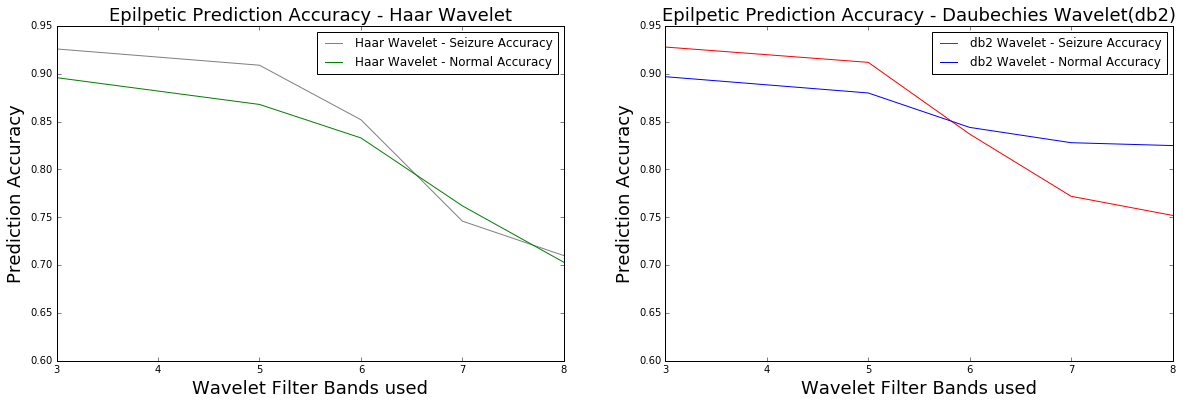

In [47]:
#plt.figure(figsize=(10,8))

fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[1].plot(filter_banks,db2["Seizure"].values, 'red', label='db2 Wavelet - Seizure Accuracy')
ax[1].plot(filter_banks,db2["Normal"].values, 'blue', label='db2 Wavelet - Normal Accuracy')
ax[0].plot(filter_banks,haar["Seizure"].values, 'grey', label='Haar Wavelet - Seizure Accuracy')
ax[0].plot(filter_banks,haar["Normal"].values, 'green', label='Haar Wavelet - Normal Accuracy')

ax[1].set_xlabel('Wavelet Filter Bands used', fontsize = 18); 
ax[1].set_ylabel('Prediction Accuracy', fontsize = 18)
ax[1].legend(loc='best')
ax[1].set_title('Epilpetic Prediction Accuracy - Daubechies Wavelet(db2)', fontsize = 18)
ax[1].set_ylim(0.6,0.95)

ax[0].set_xlabel('Wavelet Filter Bands used', fontsize = 18); 
ax[0].set_ylabel('Prediction Accuracy', fontsize = 18)
ax[0].legend(loc='best')
ax[0].set_title('Epilpetic Prediction Accuracy - Haar Wavelet', fontsize = 18)
ax[0].set_ylim(0.6,0.95)

As the wavelets are passed through higher number of filter banks, they are compressed exponentially. As we compress more, we may lose more information from the signal. This is evident from the graph that as the filter bands increases, our prediction accuracy also reduces. As mentioned earlier, the shape of the daubechies wavelet resembles the shape of the scalp EEG data. From the graph shown above, daubechies wavelet gives better accuracy even at higher filter bank levels compared to haar wavelets.

## 6. Generalization to other patients

### 6.1. Patient-specific model(power spectrum)

Previously we used data from a single patient to fit a model and make predictions. Can we use
the same model to predict seizures for other patients? Shoeb warned that multi-patient classifiers
would not be as effective. Seizures can differ dramatically between patients. Artifacts for one
13patient can look like a seizure for another patient.

The patient-specific random forest had impressive results on testing sets. We separated predictions
made during the day and the night. We do not seem to do much better at night like we
could have expected when we looked at scatter plots of the data.

In [111]:
X_training, X_testing, y_training, y_testing = train_test_split(df_power_spectrum[predictors], df_power_spectrum['label'], test_size=0.2, random_state=10)

rf = RandomForest(n_estimators=300, max_depth=2, class_weight="balanced")
rf.fit(X_training, y_training)
predictions = rf.predict(X_testing)
        
a1 = np.sum((predictions==1)&(y_testing==1))
a2 = np.sum((predictions==1)&(y_testing==0))
a3 = np.sum((predictions==0)&(y_testing==1))
a4 = np.sum((predictions==0)&(y_testing==0))
          
t = df_power_spectrum["type"]

d2 = np.sum((predictions==1)&(y_testing==0)&(t=="day"))
d4 = np.sum((predictions==0)&(y_testing==0)&(t=="day"))
n2 = np.sum((predictions==1)&(y_testing==0)&((t=="night")|(t=="before")|(t=="after")))
n4 = np.sum((predictions==0)&(y_testing==0)&((t=="night")|(t=="before")|(t=="after")))

df_pred = pd.DataFrame(columns=["Seizure","Normal - Night", "Normal - Day"], index=["Predicted Seizure","Predicted Normal"])
df_pred["Seizure"].iloc[0] = round(a1/(a1+a3+0.0),3)
df_pred["Seizure"].iloc[1] = round(a3/(a1+a3+0.0),3)
df_pred["Normal - Night"].iloc[0] = round(n2/(a2+a4+0.0) ,3)   
df_pred["Normal - Night"].iloc[1] = round(n4/(a2+a4+0.0) ,3)   
df_pred["Normal - Day"].iloc[0] = round(d2/(a2+a4+0.0) ,3)   
df_pred["Normal - Day"].iloc[1] = round(d4/(a2+a4+0.0) ,3)    

print "Accuracy on initial patient (with breakdown day/night):"
df_pred

Accuracy on initial patient (with breakdown day/night):


,Seizure,Normal - Night,Normal - Day
Predicted Seizure,0.957,0.02,0.007
Predicted Normal,0.043,0.387,0.586


In [112]:
predictions_others = rf.predict(df_power_spectrum2[predictors])

t = df_power_spectrum2["type"]
y = df_power_spectrum2["label"]

a1 = np.sum((predictions_others==1)&(y==1))
a2 = np.sum((predictions_others==1)&(y==0))
a3 = np.sum((predictions_others==0)&(y==1))
a4 = np.sum((predictions_others==0)&(y==0))

d2 = np.sum((predictions_others==1)&(y==0)&(t=="day"))
d4 = np.sum((predictions_others==0)&(y==0)&(t=="day"))
n2 = np.sum((predictions_others==1)&(y==0)&((t=="night")|(t=="before")|(t=="after")))
n4 = np.sum((predictions_others==0)&(y==0)&((t=="night")|(t=="before")|(t=="after")))
         
df_pred = pd.DataFrame(columns=["Seizure","Normal - Night", "Normal - Day"], index=["Predicted Seizure","Predicted Normal"])
df_pred["Seizure"].iloc[0] = round(a1/(a1+a3+0.0),3)
df_pred["Seizure"].iloc[1] = round(a3/(a1+a3+0.0),3)
df_pred["Normal - Night"].iloc[0] = round(n2/(a2+a4+0.0) ,3)   
df_pred["Normal - Night"].iloc[1] = round(n4/(a2+a4+0.0) ,3)   
df_pred["Normal - Day"].iloc[0] = round(d2/(a2+a4+0.0) ,3)   
df_pred["Normal - Day"].iloc[1] = round(d4/(a2+a4+0.0) ,3)    

print "Accuracy on other patients (with breakdown day/night):"
df_pred

Accuracy on other patients (with breakdown day/night):


,Seizure,Normal - Night,Normal - Day
Predicted Seizure,0.673,0.019,0.083
Predicted Normal,0.327,0.381,0.517


### 6.2. Patient specific model(DWT)

The patient specific random forest model gave the impressive results. When we applied the same model for other patients to see if we could generalize the model, similar to Power spectrum approach, false negatives increased dramatically and model accuracy
also decreased.

In [50]:
rf_model = RandomForest(n_estimators=300, max_depth=5, class_weight="balanced")
rf_model.fit(xtrain_poly, ytrain)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [51]:
patient_02_eeg = [s for s in files if "chb02" in s]
X2, Y2, eeg_df = generate_data(patient_02_eeg, 3, 'db2')
confusion_matrix(rf_model, X2, Y2)

,Seizure,Normal
Predicted Seizure,0.021,0.208
Predicted Normal,0.979,0.792


In [53]:
patient_06_eeg = [s for s in files if "chb06" in s]
X6, Y6, eeg_df = generate_data(patient_06_eeg, 3, 'db2')
confusion_matrix(rf_model, X6, Y6)

,Seizure,Normal
Predicted Seizure,0.523,0.667
Predicted Normal,0.477,0.333


In [54]:
patient_08_eeg = [s for s in files if "chb08" in s]
X8, Y8, eeg_df = generate_data(patient_08_eeg, 3, 'db2')
confusion_matrix(rf_model, X8, Y8)

,Seizure,Normal
Predicted Seizure,0.9,0.411
Predicted Normal,0.1,0.589


As you can see above, the accuracy differs for every patient. Based on this, we could arrive at a conclusion that an activity termed as epileptic for one person could be a normal activity for another person. So, based on the above, it is not possible to generalize the model across patients.

### 6.3. Multi-patient model(power spectrum)

Next we created a multi-patient model. We merged the data from 5 patients. We did the same
split of train and test with 80/20% as done before. We used the same Random Forest approach
by growing 300 trees with maximum depth of 2. Like expected this model is not as effective as
our patient-specific model. We have 20.5% of false negatives and 6.3% of false positives. It is
better though than applying a model from one patient to another.

In [109]:
df_power_spectrum3 = pd.concat([df_power_spectrum, df_power_spectrum2],ignore_index=True)
predictors = df_power_spectrum.columns[:-3]
X_training, X_testing, y_training, y_testing = train_test_split(df_power_spectrum3[predictors], df_power_spectrum3['label'], test_size=0.2, random_state=10)

rf = RandomForest(n_estimators=300, max_depth=2, class_weight="balanced")
rf.fit(X_training, y_training)
predictions = rf.predict(X_testing)
        
a1 = np.sum((predictions==1)&(y_testing==1))
a2 = np.sum((predictions==1)&(y_testing==0))
a3 = np.sum((predictions==0)&(y_testing==1))
a4 = np.sum((predictions==0)&(y_testing==0))
          
t = df_power_spectrum3['type']

d2 = np.sum((predictions==1)&(y_testing==0)&(t=="day"))
d4 = np.sum((predictions==0)&(y_testing==0)&(t=="day"))
n2 = np.sum((predictions==1)&(y_testing==0)&((t=="night")|(t=="before")|(t=="after")))
n4 = np.sum((predictions==0)&(y_testing==0)&((t=="night")|(t=="before")|(t=="after")))
         
df_pred = pd.DataFrame(columns=["Seizure","Normal - Night", "Normal - Day"], index=["Predicted Seizure","Predicted Normal"])
df_pred["Seizure"].iloc[0] = round(a1/(a1+a3+0.0),3)
df_pred["Seizure"].iloc[1] = round(a3/(a1+a3+0.0),3)
df_pred["Normal - Night"].iloc[0] = round(n2/(a2+a4+0.0) ,3)   
df_pred["Normal - Night"].iloc[1] = round(n4/(a2+a4+0.0) ,3)   
df_pred["Normal - Day"].iloc[0] = round(d2/(a2+a4+0.0) ,3)   
df_pred["Normal - Day"].iloc[1] = round(d4/(a2+a4+0.0) ,3)    

print "Multi-patient model accuracy (with breakdown day/night):"
df_pred

Multi-patient model accuracy (with breakdown day/night):


,Seizure,Normal - Night,Normal - Day
Predicted Seizure,0.875,0.009,0.014
Predicted Normal,0.125,0.404,0.574


### 6.4 Multi-patient model(DWT)

We created a multi-patient model using DWT approach also. We merged data from 4 patients.
We did the same split of train and test with 80% and 20% as done before. We applied the same
Random forest classifier with 300 trees and maximum depth of 5. The result was better than
the generalization of one patient model. But still has quite some false positives 16.6% and false
negatives 21.8%.


In [55]:
multipatient_eeg = [s for s in files if "chb" in s ]

xtrain, ytrain, xtest, ytest = poly_generate_data(multipatient_eeg, 3, 'db2')

multi_rf = RandomForest(n_estimators=300, max_depth=5, class_weight="balanced")
multi_rf.fit(xtrain, ytrain)
confusion_matrix(multi_rf,xtest,ytest)

,Seizure,Normal
Predicted Seizure,0.782,0.166
Predicted Normal,0.218,0.834


## 7. Conclusion

We presented two approaches to detect seizures based on EEG data. We first used either Fourier's Power Spectrum or Discrete Wavelets to transform the signals and extract the structure behind the noisy time series. After multiple cross validation, it seems that Random Forest with balanced classes, 300 trees and a max depth of 2 lead to the highest accuracy for class 1 (seizure). Indeed, our goal was to minimize the number of false negative, predict a normal activity while the patient is experiencing a seizure. The two transform methods provided very similar results. One approach can be considered as a cross-validation of another. Comparison of multiple approaches are essential in high risk industries such as medical.

We have proved that a patient-specific model outperforms a non-specific model. It is also impossible to use a model fit on one patient to predict seizures on another patient without a serious loss in accuracy. 


## 8. References


1. *Application of Machine Learning To Epileptic Seizure Detection* Ali Shoeb and John Guttag (MIT, 2010)

2. *Application of machine learning to epileptic seizure onset detection and treatment* Ali Shoeb (MIT PhD thesis)

3. *Signal Classiﬁcation by Power Spectral Density: From Euclid to Riemann* (K.M.Wong, 2011)

4. *EEG Signal Classification Using Power Spectral Features and linear Discriminant Analysis: A Brain Computer Interface Application* Jaime F. Delgado Saa and Miguel Sotaquirá Gutierrez (2010)

5. *Analysis of EEG records in an epileptic patient using wavelet transform* Hojjat Adeli, Ziqin Zhou, Nahid Dadmehr (Journal of Neuroscience Methods, 2003)
